# Connectivity Analysis Pipeline

This notebook is a first shot at making a connectivity analysis pipeline using **EBRAINS** atlas services through **siibra**, and **nilearn**. 

The pipeline will ideally contains the following steps:

- **Step 1:** <a href='#Step1'>Load fmri data from EBRAINS</a
- **Step 2:** <a href='#Step2'>Load a parcellation from EBRAINS human brain atlas using the `siibra` client</a>
- **Step 3:** <a href='#Step3'>Use nilearn to extract signals</a>
- **Step 4:** <a href='#Step4'>Use nilearn to compute some connectivity from these signals</a>
- **Step 5:** <a href='#Step5'>Use nilearn to visualize this connectivity (as a matrix, as a graph...)</a>
- **Step 6:** <a href='#Step6'>Upload the results back to EBRAINS</a>
- **Step 7:** Visualize them using the visualization tools of EBRAINS

## Step 1: Load fmri data

Ideally this will be loaded from **EBRAINS**. 

**TODOS:**

- [ ] find and upload good datasets
- [ ] find a way to fetch them easily 

For now, we rely on **Nilearn** for this.

<div class="alert alert-block alert-info">
<b>Tip:</b> If you don't have Nilearn installed, you can get it with pip:

$ pip install nilearn
</div>

In [1]:
# Do not display warnings to prettify the notebook...
import warnings
warnings.simplefilter("ignore")

In [2]:
# import nilearn newest version (make sure it is 0.8.0 or more)
import nilearn
nilearn.__version__

'0.9.1'

We load 10 development fmri data for 10 subjects:

In [3]:
from nilearn.datasets import fetch_development_fmri

# Ten subjects of brain development fmri data
data = fetch_development_fmri(n_subjects=10)

## Step 2: Load an atlas from EBRAINS

We rely on the `siibra` library to work with EBRAINS human brain atlas and access the *Julich-Brain Probabilistic Cytoarchitectonic Maps*. We use a recent development version which we install from github:

```
git clone https://github.com/FZJ-INM1-BDA/siibra-python.git
cd siibra-python/
pip install -e .
```

If this is the first time you use siibra, you will have to provide an authentication token. See [here](https://kg.ebrains.eu/develop.html) how to getn EBRAINS account and prepare it for API tokens. The, we just need to visit the token endpoint:

In [ ]:
import webbrowser
webbrowser.open('https://nexus-iam.humanbrainproject.org/v0/oauth2/authorize')
token = input("Enter your token here: ")

### 2.1 Fetch a parcellation object via siibra

In [ ]:
!git clone https://github.com/FZJ-INM1-BDA/siibra-python.git
!cd siibra-python/
!pip install -e .

In [10]:
import siibra
assert(siibra.__version__ >= "0.3a22")

In [11]:
with siibra.QUIET:
    siibra.set_ebrains_token(token)

Select a parcellation among the possible choices:

In [12]:
atlas = siibra.atlases['human']
parcellation = atlas.get_parcellation('julich')
print(parcellation.description)

[siibra:INFO] Multiple elements matched the specification 'julich' - the first in order was chosen: Julich-Brain Cytoarchitectonic Maps 2.9


This dataset contains the whole-brain parcellation of the Julich-Brain Cytoarchitectonic Atlas in the MNI Colin 27 as well as the MNI ICBM 152 2009c nonlinear asymmetric reference space (Evans et al., 2012). The parcellation is derived from the individual probability maps (PMs) of the cytoarchitectonic regions released in the Julich-Brain Cytoarchitectonic Atlas, that are further combined into a Maximum Probability Map (MPM). The MPM is calculated by considering for each voxel the probability of all cytoarchitectonic areas released in the atlas, and determining the most probable assignment (Eickhoff 2005). Gap maps complement cortical maps to achieve full cortical coverage.


### 2.2 Retrieve a parcellation map in MNI152 space

We load the map for this parcellation in MNI152 space. The map is an object which provides access to possibly multiple labelled 3D volumes, and keeps track of the relationship between map indices, label indices and the corresponding regions. It follows a lazy data loading scheme. In order to load image data, the `fetch()` or `fetchall()` methods are used. While the first loads image data for one particular volumetric map (with the first one as the default), the latter provides an iterator over all available maps. 

For the Julich-Brain maximum probability parcellation, the map provides two labelled volumes for the left and right hemisphere, respectively:

In [15]:
jubrain_mpm = atlas.get_map(space="mni152", maptype="labelled")
# note that the above is a short form. 
# We could also use safe autocompletion by writing
# - space=siibra.spaces.MNI152_2009C_NONL_ASYM and 
# - maptype=siibra.MapType.LABELLED 
print(f"Julich brain provides {len(jubrain_mpm)} labelled maps.")

[siibra:INFO] No parcellation specified, using default 'Julich-Brain Cytoarchitectonic Maps 2.9'.


Julich brain provides 2 labelled maps.


We iterate over the 3D image volumes, and display them:

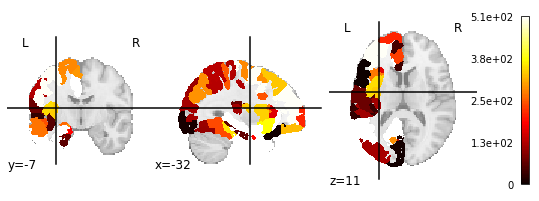

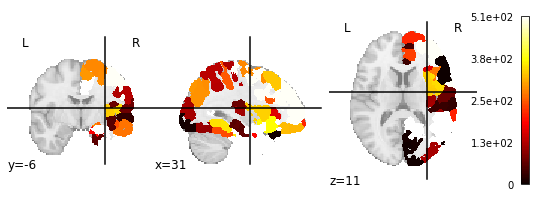

In [16]:
from nilearn import plotting
for img in jubrain_mpm.fetch_iter():
    nilearn.plotting.plot_stat_map(img)

### 2.3 Understand handling of region objects and map indices in siibra

The parcellation map allows us to decode map and label indices into region objects:

In [ ]:
region1 = jubrain_mpm.decode_label(mapindex=0, labelindex=10)
print(region1)

In [ ]:
region2 = jubrain_mpm.decode_label(mapindex=1, labelindex=10)
print(region2)

In the very same fashion we can access the more detailed probability maps for each region, by requesting the "continuous" map type. This gives us a parcellation map with hundreds of volumetric maps, each representing one brain region:

In [ ]:
jubrain_pmaps = atlas.get_map(space="mni152", maptype="continuous")

Let's find the probability map for region1 from above. Again, the parcellation map object helps us, as it can not only decode indices into regions, but also vice versa: 

In [ ]:
index = jubrain_pmaps.decode_region(region2)[0]
print(index)

As we see, the region with label 10 in the second labelled parcelation map for Julich-Brain, which is "hOc3v right", is the 93rd map in the probability map object. It has no labelindex, since all its voxels have different values, as they represent a continuous distribution in space. 

Let's fetch and plot the map:

In [ ]:
plotting.plot_stat_map(jubrain_pmaps.fetch(mapindex=index.map))

But in fact, fetching a single region's map can also be done much easier:

[siibra:INFO] Returning map 90 of in total 302 available maps.


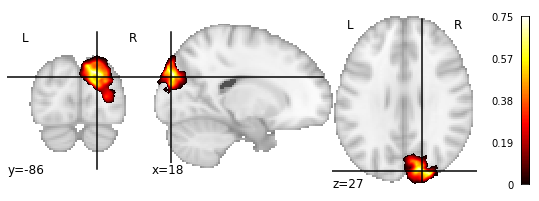

In [13]:
plotting.plot_stat_map(jubrain_pmaps.fetch_regionmap("hoc3v right"))

For the maximum probability map, the same will give us a binary mask of that region:

[siibra:INFO] Returning map 2 of in total 2 available maps.


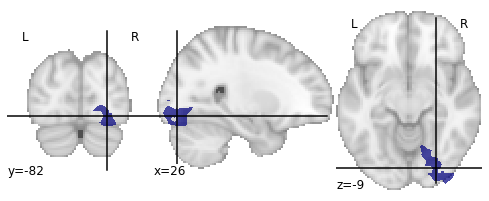

In [14]:
plotting.plot_roi(jubrain_mpm.fetch_regionmap("hoc3v right"))

## Step 3: Use Nilearn to extract signals from parcellation and functional data

In this section we use the nilearn `NiftiLabelsMasker` to extract the signals from the functional dataset and parcellation.

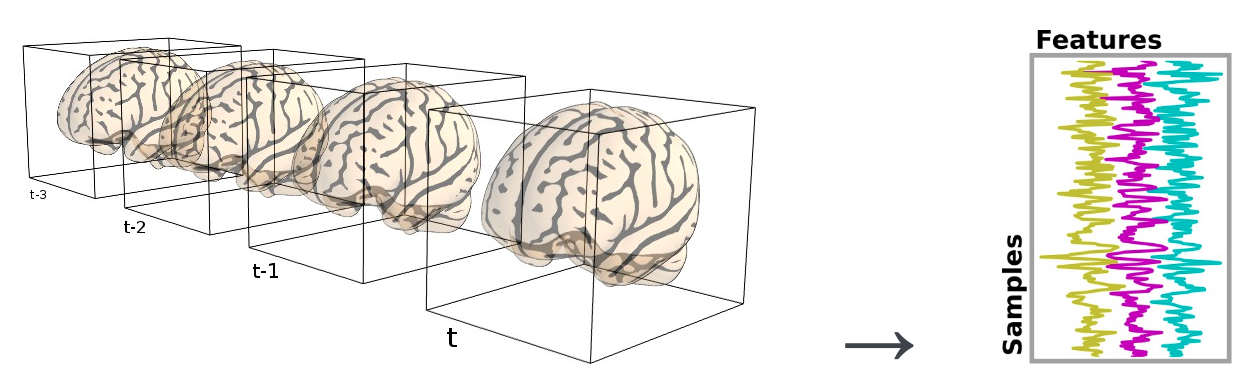

In [15]:
from IPython.display import Image
Image(filename='masker.png') 

*copyright - Image taken from the nilearn documentation.*

More information on maskers can be found in the <a href="https://nilearn.github.io/manipulating_images/masker_objects.html">nilearn online documentation</a>.

For masking, we use only left hemisphere parcellation map of Julich-Brain.

**TODO: here we input the map with 147 different labels (plus background 0), but the masker gives us only 146 regional signals. How does the masker map labels to outputs? If it doesn't use all for some reasone, it should provide a mapping of input labels to output indices.**

The parcellation and data images have different resolutions, which will have to be handled when computing the signals:

In [16]:
parcellation_map_niimg = jubrain_mpm.fetch(mapindex=0)
parcellation_map_niimg.affine

[siibra:INFO] Returning map 1 of in total 2 available maps.


array([[   1.,    0.,    0.,  -96.],
       [   0.,    1.,    0., -132.],
       [   0.,    0.,    1.,  -78.],
       [   0.,    0.,    0.,    1.]])

In [17]:
from nilearn.image import load_img
load_img(data.func[0]).affine

array([[   4.,    0.,    0.,  -96.],
       [   0.,    4.,    0., -132.],
       [   0.,    0.,    4.,  -78.],
       [   0.,    0.,    0.,    1.]])

In [18]:
from nilearn.input_data import NiftiLabelsMasker
import numpy as np

names = {
    int(index.label):region.name 
    for index, region in jubrain_mpm.regions.items()
}
labels = list(names.values())

# Use NiftiLabelsMasker to extract signals from regions
# Note that the masker will resample the parcellation to
# the data image resolution.
masker = NiftiLabelsMasker(labels_img = parcellation_map_niimg, 
                           labels = labels,
                           background_label=0, # Default value, for clarity
                           resampling_target="data", # Default value
                           standardize=True) # Standardize the signals
time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, 
                                            confounds=confounds))

labels = [names[l] for l in masker.labels_]
# Small region got wiped out of the label image
# which results in only 146 signals instead of 147
assert 'MF (Amygdala) right' not in labels

time_series = np.array(time_series)
time_series.shape, len(names), len(np.unique(parcellation_map_niimg.get_fdata())), len(labels)

((10, 168, 146), 147, 148, 146)

We have **146** standardized time series of length **168** per subject (**10** subjects were loaded). 

We can plot them if needed:

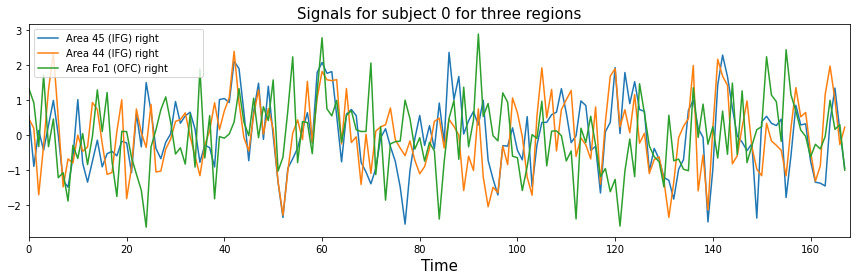

In [19]:
import matplotlib.pyplot as plt

subject_id = 0
fig = plt.figure(figsize=(12,4))
for i in [0,1,2]:
    plt.plot(time_series[subject_id, :, i], 
             label=f"{labels[i]:30.30}")
plt.legend()
plt.xlim((0, 168))
plt.xlabel("Time", fontsize=15)
plt.title(f"Signals for subject {subject_id} for three regions", fontsize=15)
plt.tight_layout()

## Step 4: Use Nilearn to compute a connectivity matrix

Here we compute the correlation between these time series:

In [20]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform(time_series)
assert correlation_matrix.shape == (10, 146, 146)

In order to visualize this matrix, we take the mean accross subject:

In [21]:
mean_correlation_matrix = correlation_measure.mean_
assert mean_correlation_matrix.shape == (146, 146)

## Step 5: Use nilearn to visualize the connectivity

We can use **Nilearn** to visualize the connectivity, either as a matrix or as a graph:

### As a matrix

We can plot the matrix with the region names:

In [22]:
mean_correlation_matrix.shape, len(labels)

((146, 146), 146)

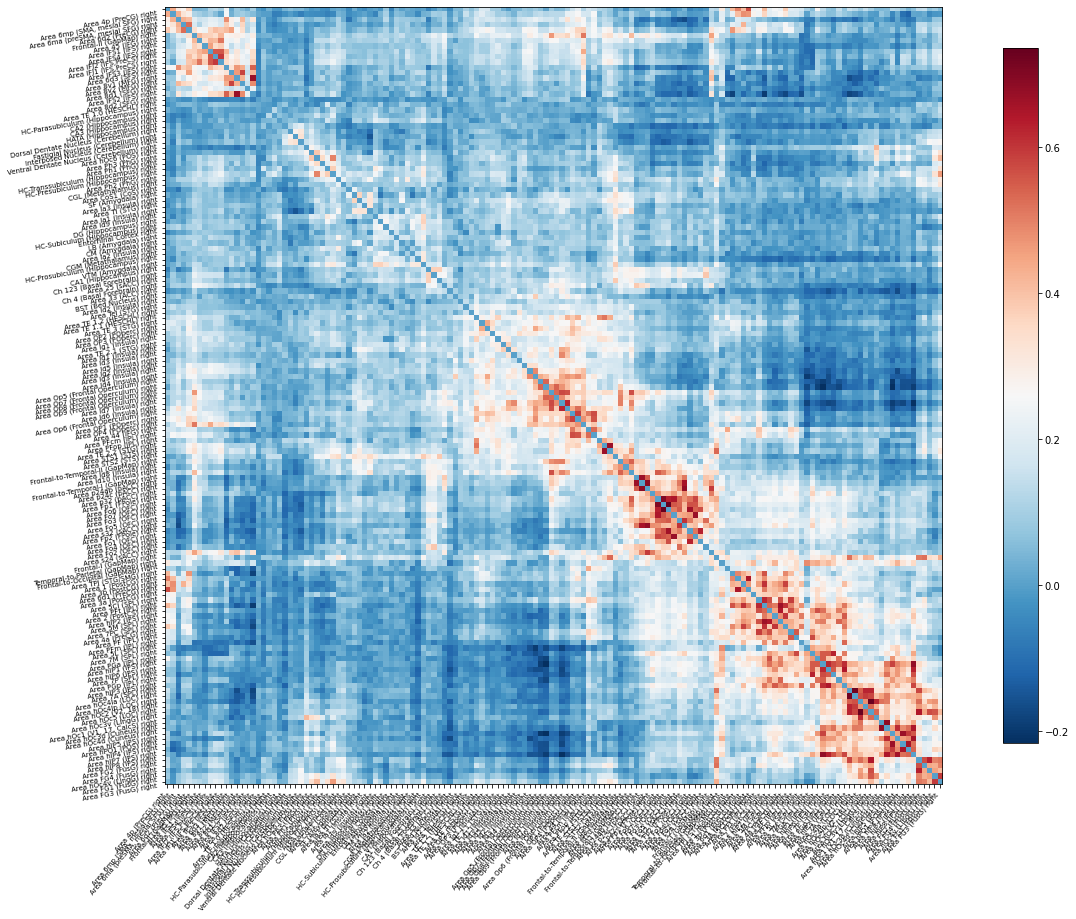

In [23]:
from nilearn.plotting import plot_matrix
# Mask the main diagonal for visualization:
np.fill_diagonal(mean_correlation_matrix, 0)
# matrices are ordered for block-like representation
plot_matrix(mean_correlation_matrix, 
            figure=(16, 16), 
            labels=labels, 
            reorder=True)

### As a graph

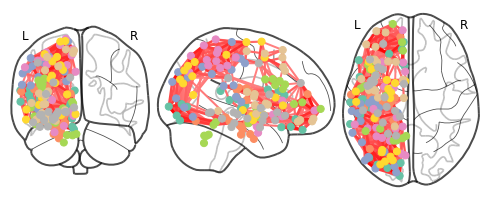

In [24]:
from nilearn.plotting import plot_connectome, find_parcellation_cut_coords

# grab center coordinates for atlas labels
# !!!!! UGLY HACK ALERT !!!!!
# I'm passing the resampled label image from the masker to avoid shape errors
coordinates = find_parcellation_cut_coords(labels_img=masker._resampled_labels_img_)
# plot connectome with 95% edge strength in the connectivity
plot_connectome(mean_correlation_matrix, 
                coordinates,
                edge_threshold="95%")

## Step 6: Upload the results back to ebrains

**TODOS:**

- Decide on a representation of the connectivity results
- Find how these results could be uploaded

In [ ]:
from siibra.features.connectivity import ConnectivityMatrix

In [ ]:
m = ConnectivityMatrix(parcellation_map_niimg, 
                       mean_correlation_matrix, 
                       names, 
                       None, None) # What are these?

In [ ]:
m.parcellation